This notebook compares our best model -- random forest -- to the baseline model.

# Pre-processing

In [151]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from datetime import datetime
from datetime import date

In [152]:
#create dataframe
df = pd.read_csv("../Data/pharmacy_tx.csv")
df.head()

,tx_date,pharmacy,diagnosis,drug,bin,pcn,group,rejected,patient_pay
0,2022-01-02,Pharmacy #6,G99.93,branded tanoclolol,725700,1UQC,NaN,False,13.39
1,2022-01-02,Pharmacy #42,U60.52,branded oxasoted,664344,NaN,52H8KH0F83K,False,7.02
2,2022-01-02,Pharmacy #37,Q85.91,branded cupitelol,725700,1UQC,NaN,False,13.39
3,2022-01-02,Pharmacy #30,U60.52,generic oxasoted,571569,KB38N,6BYJBW,False,10.84
4,2022-01-02,Pharmacy #18,N55.01,branded mamate,664344,NaN,ZX2QUWR,False,47.00


In [153]:
def get_doy(d):
    return d.dayofyear

In [154]:
#convert date to integer between 1 and 365
df['day'] = pd.to_datetime(df.tx_date).apply(get_doy)
df = df.drop(columns = ['tx_date'])
df.head()

,pharmacy,diagnosis,drug,bin,pcn,group,rejected,patient_pay,day
0,Pharmacy #6,G99.93,branded tanoclolol,725700,1UQC,NaN,False,13.39,2
1,Pharmacy #42,U60.52,branded oxasoted,664344,NaN,52H8KH0F83K,False,7.02,2
2,Pharmacy #37,Q85.91,branded cupitelol,725700,1UQC,NaN,False,13.39,2
3,Pharmacy #30,U60.52,generic oxasoted,571569,KB38N,6BYJBW,False,10.84,2
4,Pharmacy #18,N55.01,branded mamate,664344,NaN,ZX2QUWR,False,47.00,2


In [155]:
#drop rejected column
df = df[df['rejected']==False]
df = df.drop(columns = ['rejected'])

In [156]:
#drop additional extraneous columns; convert bin to str so that one-hot encoding works correctly
df = df.drop(columns = ['pharmacy', 'group', 'pcn'])
df['bin'] = df['bin'].map(str)
df.head()

,diagnosis,drug,bin,patient_pay,day
0,G99.93,branded tanoclolol,725700,13.39,2
1,U60.52,branded oxasoted,664344,7.02,2
2,Q85.91,branded cupitelol,725700,13.39,2
3,U60.52,generic oxasoted,571569,10.84,2
4,N55.01,branded mamate,664344,47.00,2


In [157]:
#make a column for branded/generic
df['drug_type'] = df['drug'].apply(lambda x: x.split(' ')[0])
df['drug'] = df['drug'].apply(lambda x: x.split(' ')[1])
df.head()

,diagnosis,drug,bin,patient_pay,day,drug_type
0,G99.93,tanoclolol,725700,13.39,2,branded
1,U60.52,oxasoted,664344,7.02,2,branded
2,Q85.91,cupitelol,725700,13.39,2,branded
3,U60.52,oxasoted,571569,10.84,2,generic
4,N55.01,mamate,664344,47.00,2,branded


In [158]:
#separate out X and y
df= df[['day', 'drug_type', 'drug', 'diagnosis', 'bin', 'patient_pay']]
X = df.copy()
y = X.iloc[:,-1]
X = X.drop(columns = ['patient_pay'])

In [159]:
#one-hot encoding
X = pd.get_dummies(X, drop_first = True)

In [160]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

In [161]:
X_train.head()

,day,drug_type_generic,drug_bovirol,drug_brede,drug_choxestamenium,drug_cibroniudosin,drug_cicrochoric,drug_colade,drug_colifunene,drug_cupitelol,...,bin_539437,bin_571569,bin_664344,bin_691847,bin_718350,bin_725700,bin_756120,bin_757349,bin_956971,bin_96934
5197337,146,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
643154,20,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
11999316,317,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2548632,75,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
13471059,351,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


# Random Forest

In [162]:
from sklearn.ensemble import RandomForestRegressor

In [163]:
#fits model on sample_prop proportion of the data n_sample times. Makes predictions on test set, and averages
#to produce a single prediction. Returns KPIs of prediction.

def run_model_samples(model, X_train, y_train, X_test, y_test, n_samples, sample_prop):
    preds = np.zeros((n_samples, len(y_test)))
    for i in range(n_samples):
        #Get random subset
        I = np.random.choice(X_train.index, size = int(sample_prop*len(X_train)), replace = False)

        #Get sub-datasets
        X_tt, y_tt = X_train.loc[I], y_train.loc[I]
        
        # Fit Model
        model.fit(X_tt,y_tt)
    
        # Get Prediction for each sample
        preds[i] = np.array(list(map(relu,model.predict(X_test))))
    
    #Average predictions
    avg_preds = np.mean(preds, axis = 0)
    
    #Calculate KPIs of average predictions
    rmse = np.sqrt(mean_squared_error(y_test, avg_preds))
    print(f'RMSE : {rmse}')
    rmsle = mean_squared_log_error(y_test, avg_preds, squared = False)
    print(f'RMLSE: {rmsle}')
    return avg_preds

In [164]:
def relu(x):
    return max(0,x)

In [165]:
avg_models = {}

In [168]:
#Construct RF model (with 10 trees)
n =10
rfr_model = RandomForestRegressor(n_estimators=n)
avg_models[n] = run_model_samples(rfr_model, X_train, y_train, X_test, y_test, 10, 0.1)

RMSE : 15.669115249120003
RMLSE: 0.3431662078386997


# Comparing Errors of RF Model and Baseline Model

In [182]:
#Compute error of RF model
y_pred = avg_models[10]
y_err = y_pred - y_test

<AxesSubplot:>

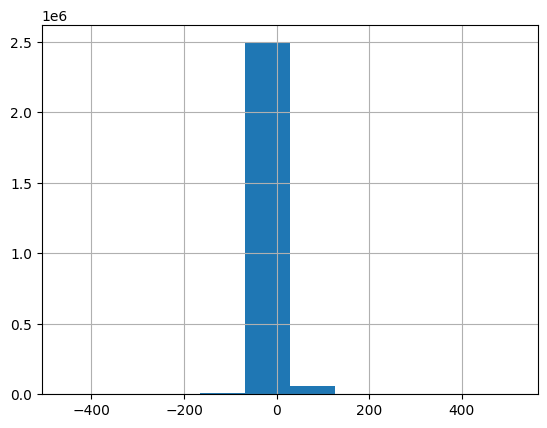

In [184]:
#Plot errors 
y_err.hist()

There seem to be some extreme outliers -- need to narrow the range to get clearer picture of shape.

(array([  6339.,   6888.,   8275.,  11284.,  14289.,  17250.,  19650.,
         27430.,  30806.,  38304.,  42406.,  53226.,  65510.,  81820.,
         98148., 164595., 298200., 585744., 183095., 129548., 107092.,
         78798.,  60294.,  43409.,  35224.,  28570.,  25116.,  20427.,
         14519.,  11953.]),
 array([-13.01278357, -12.2544174 , -11.49605123, -10.73768506,
         -9.9793189 ,  -9.22095273,  -8.46258656,  -7.70422039,
         -6.94585423,  -6.18748806,  -5.42912189,  -4.67075572,
         -3.91238956,  -3.15402339,  -2.39565722,  -1.63729105,
         -0.87892489,  -0.12055872,   0.63780745,   1.39617361,
          2.15453978,   2.91290595,   3.67127212,   4.42963828,
          5.18800445,   5.94637062,   6.70473679,   7.46310295,
          8.22146912,   8.97983529,   9.73820146]),
 <BarContainer object of 30 artists>)

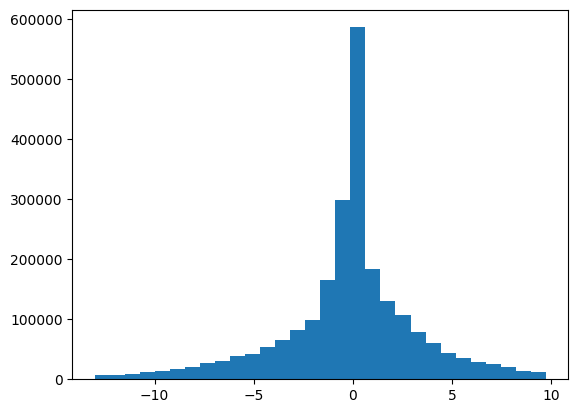

In [195]:
#Histogram of middle 90% of RF errors
plt.hist(y_err, range=(np.percentile(y_err, 5), np.percentile(y_err,95)), bins=30)

Text(0.5, 1.0, 'Random Forest Precition Error Boxplot')

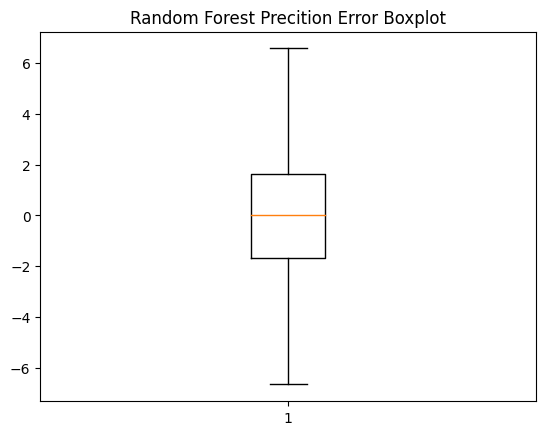

In [216]:
#Boxplot of RF errors
plt.boxplot(y_err, showfliers = False)
plt.title('Random Forest Precition Error Boxplot')

In [205]:
#Biggest RF errors
min(y_err), max(y_err)

(-458.76550499999996, 515.460065)

In [225]:
#About 90% of errors are < 16, which is about what the RMSE is. Shows the impact of outliers on RMSE.
np.percentile(y_err, 96.5), np.percentile(y_err, 4)

(15.525708123359909, -16.528956945598846)

Text(0.5, 1.0, 'Random Forest Prediction Error by Percentile')

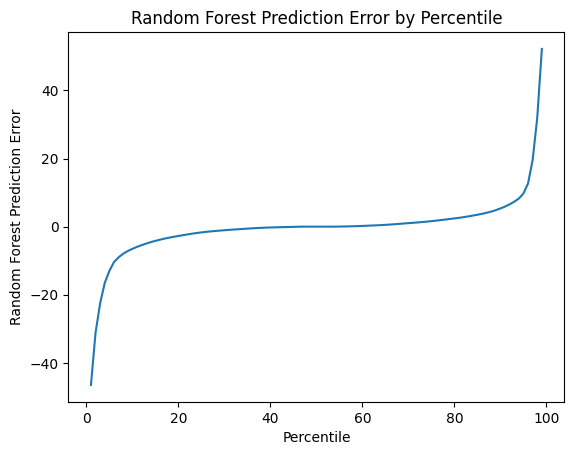

In [215]:
#Percentile curve for RF error
plt.plot(np.arange(1,100), [np.percentile(y_err,i) for i in range(1,100)])
plt.xlabel('Percentile')
plt.ylabel('Random Forest Prediction Error')
plt.title('Random Forest Prediction Error by Percentile')

In [231]:
#Constructs baseline predictions.
avg_pay = np.mean(y_train)
baseline_pred = avg_pay*np.ones_like(y_test)

In [232]:
#Computes baseline error
baseline_err = baseline_pred-y_test

Text(0.5, 1.0, 'Baseline Prediction Error by Percentile')

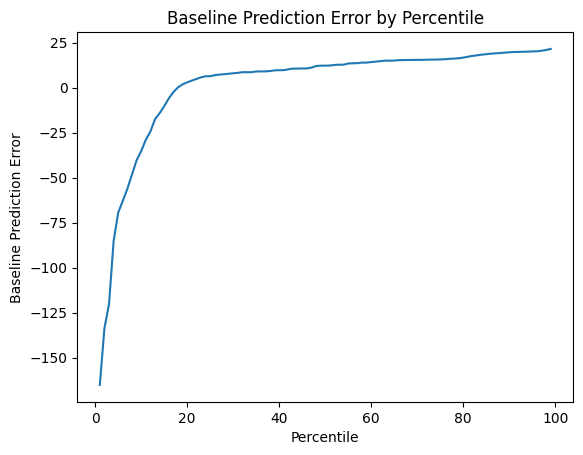

In [233]:
#Percentile curve for baseline error
plt.plot(np.arange(1,100), [np.percentile(baseline_err,i) for i in range(1,100)])
plt.xlabel('Percentile')
plt.ylabel('Baseline Prediction Error')
plt.title('Baseline Prediction Error by Percentile')

Text(0.5, 1.0, 'Baseline Precition Error Boxplot')

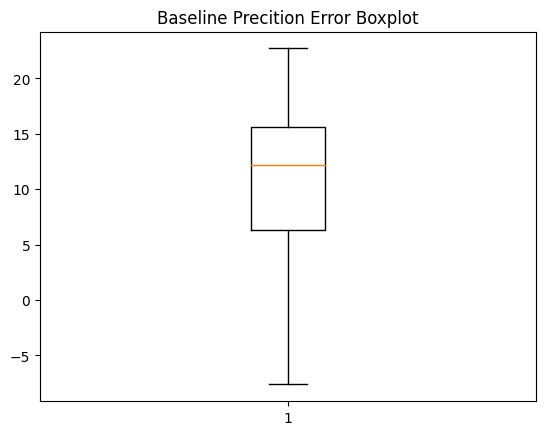

In [240]:
#Box plot for baseline error
plt.boxplot(baseline_err, showfliers = False)
plt.title('Baseline Precition Error Boxplot')

In [271]:
from scipy.stats import skew
from scipy.stats import kurtosis

In [242]:
#Comparing some more summary statistics
np.var(baseline_err), np.skew(baseline_err)

40.54467763756898

In [245]:
skew(y_err)

3.5164950706733973

In [246]:
skew(baseline_err)

-5.176648461083766

In [249]:
kurtosis(y_err)

120.74730259908642

In [251]:
kurtosis(baseline_err)

40.61886572333926

In [254]:
X_test['baseline_err'] = baseline_err

In [264]:
#Finding middle-98% cut-offs for RF, baseline errors
err_min,err_max = np.percentile(y_err, 1), np.percentile(y_err, 99)
berr_min, berr_max = np.percentile(baseline_err, 1), np.percentile(baseline_err, 99)

In [265]:
#Taking points that are in the middle 98% of both distributions
X_test_no = X_test[X_test['err']> err_min][X_test['err']< err_max]
X_test_no = X_test_no[X_test_no['baseline_err']> berr_min][X_test_no['baseline_err']< berr_max]

/var/folders/6h/7cf12br100q1zq0whpzs2tc00000gn/T/ipykernel_89577/408375495.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_test_no = X_test[X_test['err']> err_min][X_test['err']< err_max]
/var/folders/6h/7cf12br100q1zq0whpzs2tc00000gn/T/ipykernel_89577/408375495.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_test_no = X_test_no[X_test_no['baseline_err']> berr_min][X_test_no['baseline_err']< berr_max]


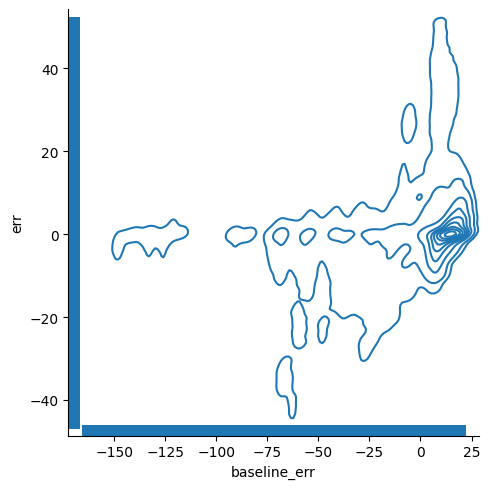

In [269]:
#A visualization of the joint distribution of baseline error and RF error
sns.displot(X_test_no, x='baseline_err', y = 'err', kind = 'kde', rug = True)